# Feature Importance Analysis for Polymarket Election Markets

This notebook performs a comprehensive feature importance analysis for Polymarket election market data, using three different models:
1. Gradient Boosting Regressor
2. Random Forest Regressor
3. Linear Regression with L1 Regularization (Lasso)

The analysis includes:
- Model-specific importance
- Permutation importance (model-agnostic)
- SHAP values for the best-performing model
- Consensus feature ranking

## 1. Import Libraries and Setup

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import shap
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Set up directories
INPUT_DIR = "modified_analysis"
OUTPUT_DIR = "feature_importance_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Results will be saved to: {OUTPUT_DIR}")

# Create a timestamp for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"Analysis started at: {timestamp}")

Results will be saved to: feature_importance_results
Analysis started at: 20250315_154501


In [24]:
# Load the preprocessed data
print("Loading preprocessed data...")
try:
    X_train = np.load(os.path.join(INPUT_DIR, 'X_train_preprocessed.npy'))
    X_test = np.load(os.path.join(INPUT_DIR, 'X_test_preprocessed.npy'))
    
    # Load Brier score target (primary)
    y_train_brier = np.load(os.path.join(INPUT_DIR, 'y_train_brier_score.npy'))
    y_test_brier = np.load(os.path.join(INPUT_DIR, 'y_test_brier_score.npy'))
    
    # Load log loss target (secondary)
    y_train_logloss = np.load(os.path.join(INPUT_DIR, 'y_train_log_loss.npy'))
    y_test_logloss = np.load(os.path.join(INPUT_DIR, 'y_test_log_loss.npy'))
    
    # Load binary target (for reference)
    y_train_binary = np.load(os.path.join(INPUT_DIR, 'y_train_prediction_correct.npy'))
    y_test_binary = np.load(os.path.join(INPUT_DIR, 'y_test_prediction_correct.npy'))
    
    # Load feature names
    feature_names_path = os.path.join(INPUT_DIR, 'transformed_feature_names.csv')
    feature_names = pd.read_csv(feature_names_path)['feature'].tolist()
    
    print(f"Loaded data with {X_train.shape[1]} features, {len(y_train_brier)} training samples, and {len(y_test_brier)} test samples.")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please make sure the preprocessed files exist in the 'modified_analysis' directory.")

Loading preprocessed data...
Loaded data with 38 features, 341 training samples, and 147 test samples.


<Figure size 1200x800 with 0 Axes>

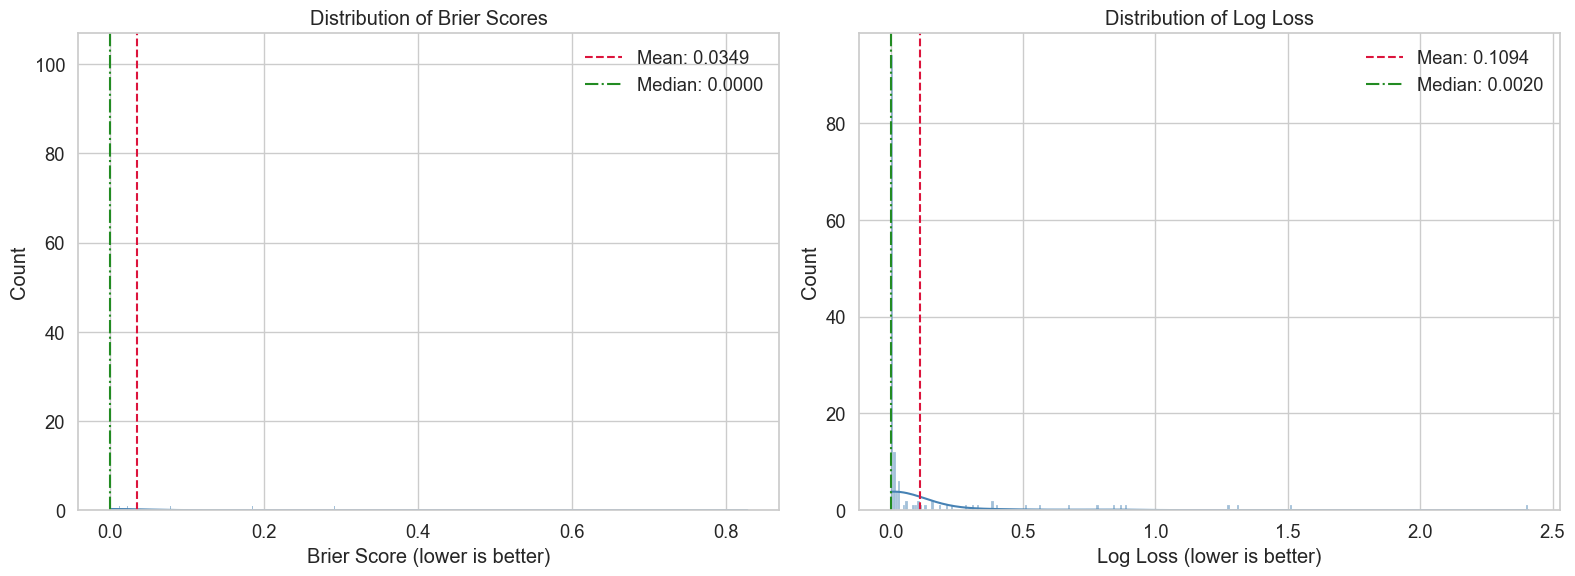

In [25]:
# Plot distributions of target variables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Brier score distribution
sns.histplot(y_test_brier, kde=True, ax=axes[0], color='steelblue')
axes[0].axvline(y_test_brier.mean(), color='crimson', linestyle='--', 
                label=f'Mean: {y_test_brier.mean():.4f}')
axes[0].axvline(np.median(y_test_brier), color='forestgreen', linestyle='-.', 
                label=f'Median: {np.median(y_test_brier):.4f}')
axes[0].set_title('Distribution of Brier Scores')
axes[0].set_xlabel('Brier Score (lower is better)')
axes[0].legend()

# Log loss distribution
sns.histplot(y_test_logloss, kde=True, ax=axes[1], color='steelblue')
axes[1].axvline(y_test_logloss.mean(), color='crimson', linestyle='--', 
                label=f'Mean: {y_test_logloss.mean():.4f}')
axes[1].axvline(np.median(y_test_logloss), color='forestgreen', linestyle='-.', 
                label=f'Median: {np.median(y_test_logloss):.4f}')
axes[1].set_title('Distribution of Log Loss')
axes[1].set_xlabel('Log Loss (lower is better)')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'target_distributions.png'), dpi=300)
plt.show()

## 2. Model Training and Evaluation

Train three regression models to predict Brier score:
1. Gradient Boosting Regressor
2. Random Forest Regressor
3. Lasso Regression (L1 regularization)

In [26]:
# Dictionary to store models and their parameters
models_config = {
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
        'params': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5}
    },
    'Random Forest': {
        'model': RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
        'params': {'n_estimators': 100, 'max_depth': 10}
    },
    'Lasso Regression': {
        'model': Lasso(alpha=0.01, max_iter=10000, random_state=42),
        'params': {'alpha': 0.01, 'max_iter': 10000}
    }
}

In [27]:
# Train all models and collect results
results = {}
for name, config in models_config.items():
    print(f"\nTraining {name}...")
    model = config['model']
    
    # Train model on Brier score
    model.fit(X_train, y_train_brier)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_brier, y_pred))
    mae = mean_absolute_error(y_test_brier, y_pred)
    r2 = r2_score(y_test_brier, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    }
    
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R²: {r2:.6f}")


Training Gradient Boosting...
  RMSE: 0.102163
  MAE: 0.030994
  R²: 0.242454

Training Random Forest...
  RMSE: 0.094103
  MAE: 0.029570
  R²: 0.357274

Training Lasso Regression...
  RMSE: 0.104941
  MAE: 0.044274
  R²: 0.200703


In [28]:
# Compare model performance
comparison_data = [
    {
        'Model': name,
        'RMSE': result['rmse'],
        'MAE': result['mae'],
        'R²': result['r2']
    }
    for name, result in results.items()
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('RMSE', ascending=True)

print("Model Performance Comparison:")
comparison_df

# Save to CSV
comparison_path = os.path.join(OUTPUT_DIR, 'model_performance_comparison.csv')
comparison_df.to_csv(comparison_path, index=False)

# Determine best model based on RMSE
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest model based on RMSE: {best_model_name}")

Model Performance Comparison:

Best model based on RMSE: Random Forest


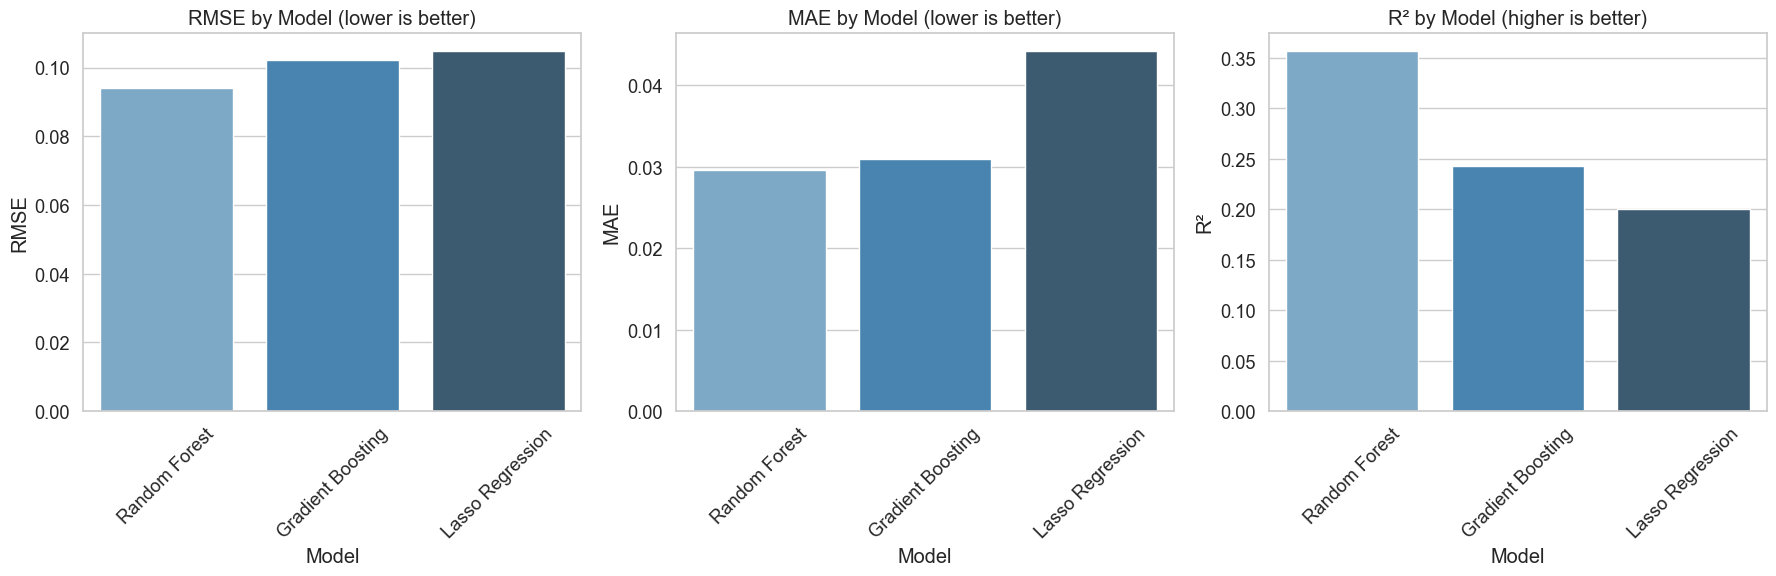

In [29]:
# Visualize model performance comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE comparison
comparison_df_sorted = comparison_df.sort_values('RMSE')
sns.barplot(x='Model', y='RMSE', data=comparison_df_sorted, ax=axes[0], palette='Blues_d')
axes[0].set_title('RMSE by Model (lower is better)')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
comparison_df_sorted = comparison_df.sort_values('MAE')
sns.barplot(x='Model', y='MAE', data=comparison_df_sorted, ax=axes[1], palette='Blues_d')
axes[1].set_title('MAE by Model (lower is better)')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
comparison_df_sorted = comparison_df.sort_values('R²', ascending=False)
sns.barplot(x='Model', y='R²', data=comparison_df_sorted, ax=axes[2], palette='Blues_d')
axes[2].set_title('R² by Model (higher is better)')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_comparison.png'), dpi=300)
plt.show()

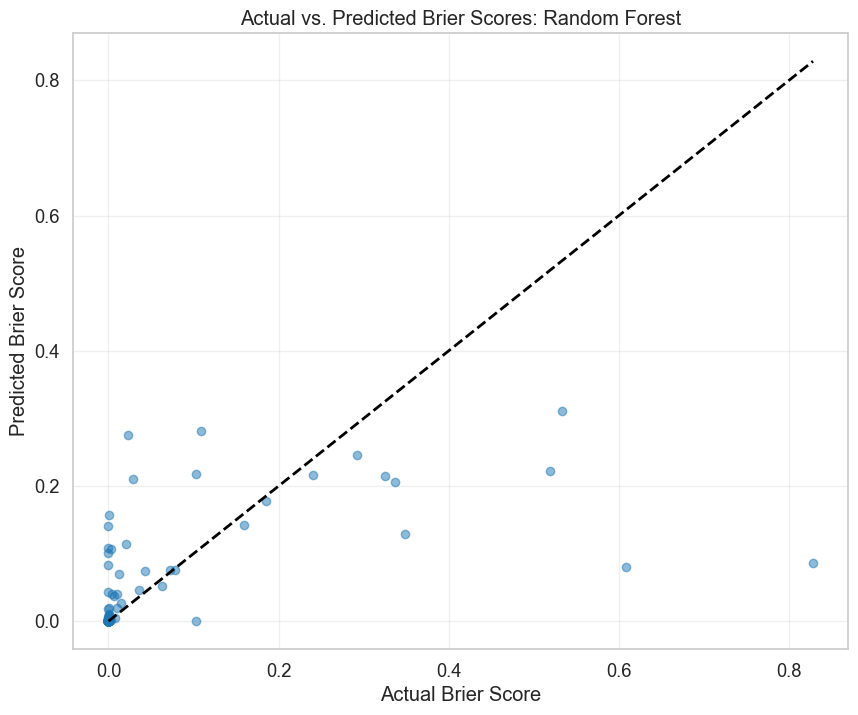

In [30]:
# Plot actual vs. predicted values for best model
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred']

plt.figure(figsize=(10, 8))
plt.scatter(y_test_brier, y_pred_best, alpha=0.5)
plt.plot([y_test_brier.min(), y_test_brier.max()], 
         [y_test_brier.min(), y_test_brier.max()], 
         'k--', lw=2)
plt.xlabel('Actual Brier Score')
plt.ylabel('Predicted Brier Score')
plt.title(f'Actual vs. Predicted Brier Scores: {best_model_name}')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, f'{best_model_name.replace(" ", "_").lower()}_actual_vs_predicted.png'), dpi=300)
plt.show()

## 3. Model-Specific Feature Importance

Next, we'll extract feature importance from each model using its native method.

In [31]:
importance_methods = {}

In [32]:
def analyze_rf_importance(model, feature_names):
    """Extract feature importance from Random Forest model"""
    if not isinstance(model, RandomForestRegressor):
        print("Model is not a Random Forest. Skipping this analysis.")
        return None
    
    print("\nExtracting Random Forest feature importance...")
    rf_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=rf_importances.head(20))
    plt.title('Top 20 Features - Random Forest')
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_DIR, 'rf_feature_importance.png')
    plt.savefig(output_path, dpi=300)
    plt.show()
    
    # Save importance scores
    rf_importances.to_csv(os.path.join(OUTPUT_DIR, 'rf_feature_importance.csv'), index=False)
    print(f"Random Forest feature importance saved to {OUTPUT_DIR}")
    
    return rf_importances

In [33]:
def analyze_gb_importance(model, feature_names):
    """Extract feature importance from Gradient Boosting model"""
    if not isinstance(model, GradientBoostingRegressor):
        print("Model is not a Gradient Boosting Regressor. Skipping this analysis.")
        return None
    
    print("\nExtracting Gradient Boosting feature importance...")
    gb_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=gb_importances.head(20))
    plt.title('Top 20 Features - Gradient Boosting')
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_DIR, 'gb_feature_importance.png')
    plt.savefig(output_path, dpi=300)
    plt.show()
    
    # Save importance scores
    gb_importances.to_csv(os.path.join(OUTPUT_DIR, 'gb_feature_importance.csv'), index=False)
    print(f"Gradient Boosting feature importance saved to {OUTPUT_DIR}")
    
    return gb_importances

In [34]:
def analyze_lasso_coefficients(model, feature_names):
    """Extract coefficients from Lasso regression model"""
    if not isinstance(model, Lasso):
        print("Model is not a Lasso Regression. Skipping this analysis.")
        return None
    
    print("\nExtracting Lasso regression coefficients...")
    coef = model.coef_
    lasso_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coef
    })
    
    # Sort by absolute coefficient value
    lasso_importance['abs_coef'] = lasso_importance['coefficient'].abs()
    lasso_importance = lasso_importance.sort_values('abs_coef', ascending=False)
    
    # Count non-zero coefficients
    non_zero = (lasso_importance['coefficient'] != 0).sum()
    print(f"Lasso selected {non_zero} features out of {len(feature_names)}")
    
    # Plot top coefficients
    plt.figure(figsize=(12, 8))
    top_coefs = lasso_importance.head(20)
    sns.barplot(x='coefficient', y='feature', data=top_coefs)
    plt.title('Top 20 Features - Lasso Regression')
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_DIR, 'lasso_coefficients.png')
    plt.savefig(output_path, dpi=300)
    plt.show()
    
    # Save coefficients
    lasso_importance.to_csv(os.path.join(OUTPUT_DIR, 'lasso_coefficients.csv'), index=False)
    print(f"Lasso regression coefficients saved to {OUTPUT_DIR}")
    
    return lasso_importance


Extracting Random Forest feature importance...


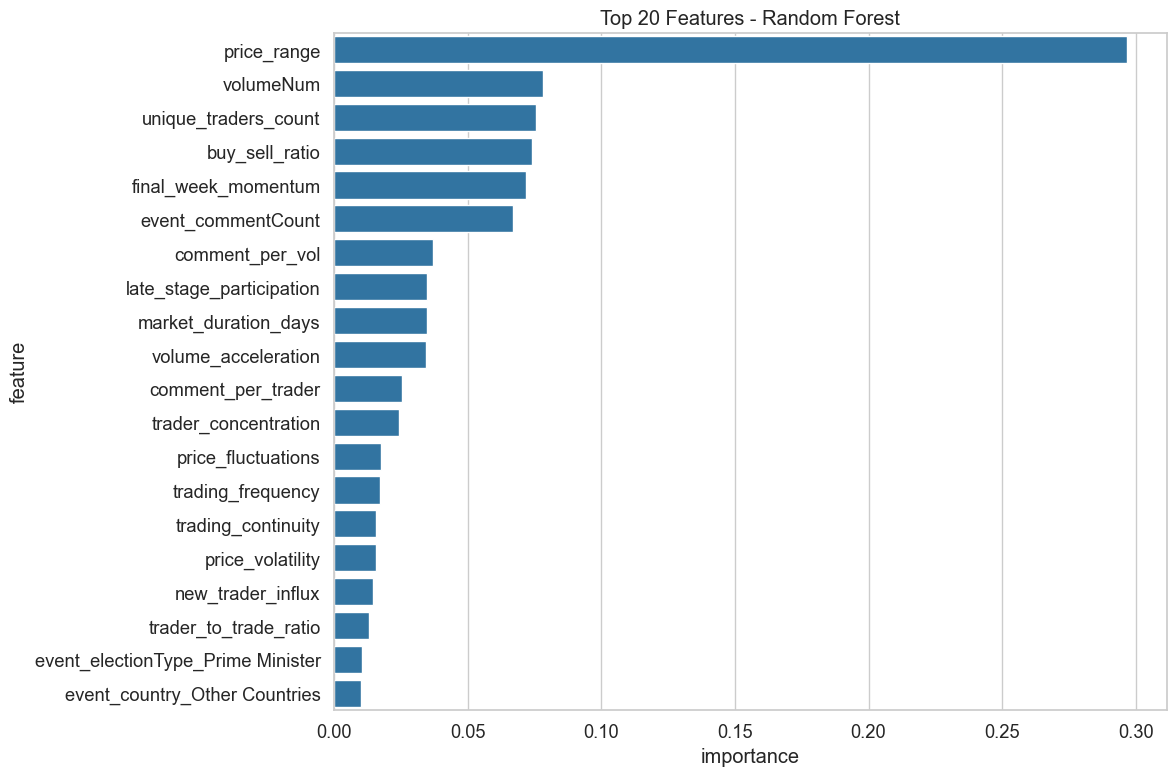

Random Forest feature importance saved to feature_importance_results

Extracting Gradient Boosting feature importance...


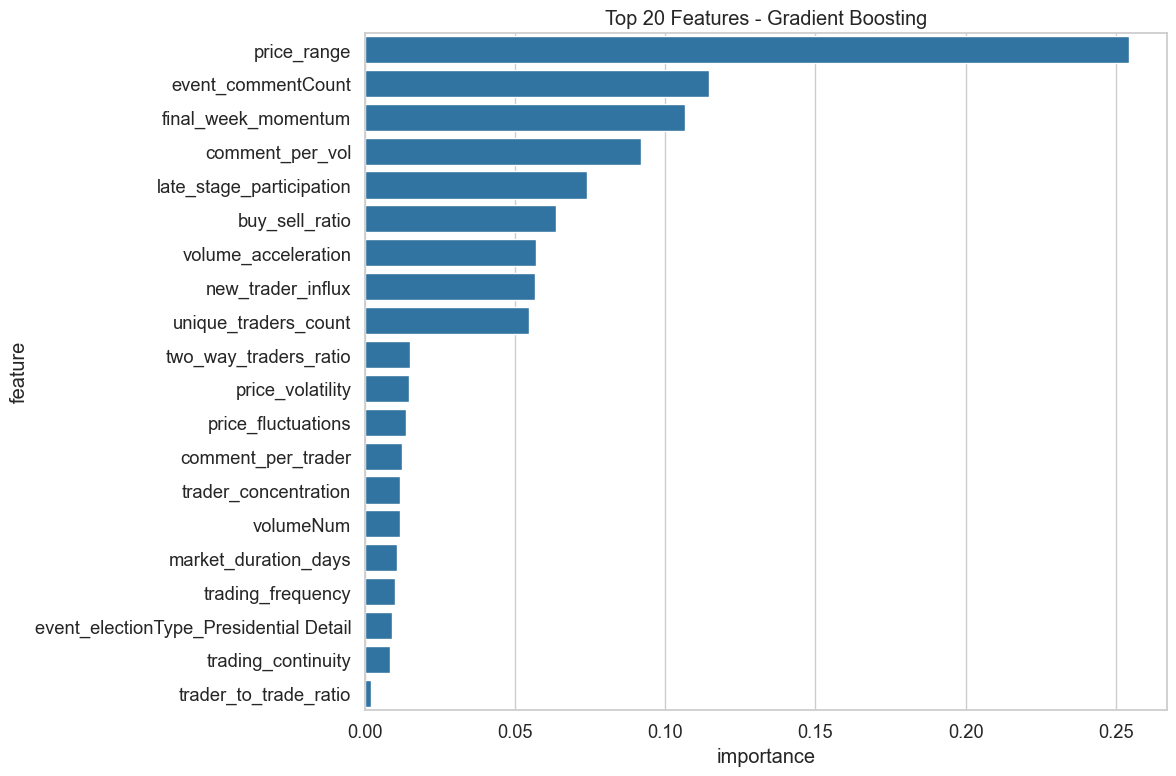

Gradient Boosting feature importance saved to feature_importance_results

Extracting Lasso regression coefficients...
Lasso selected 5 features out of 38


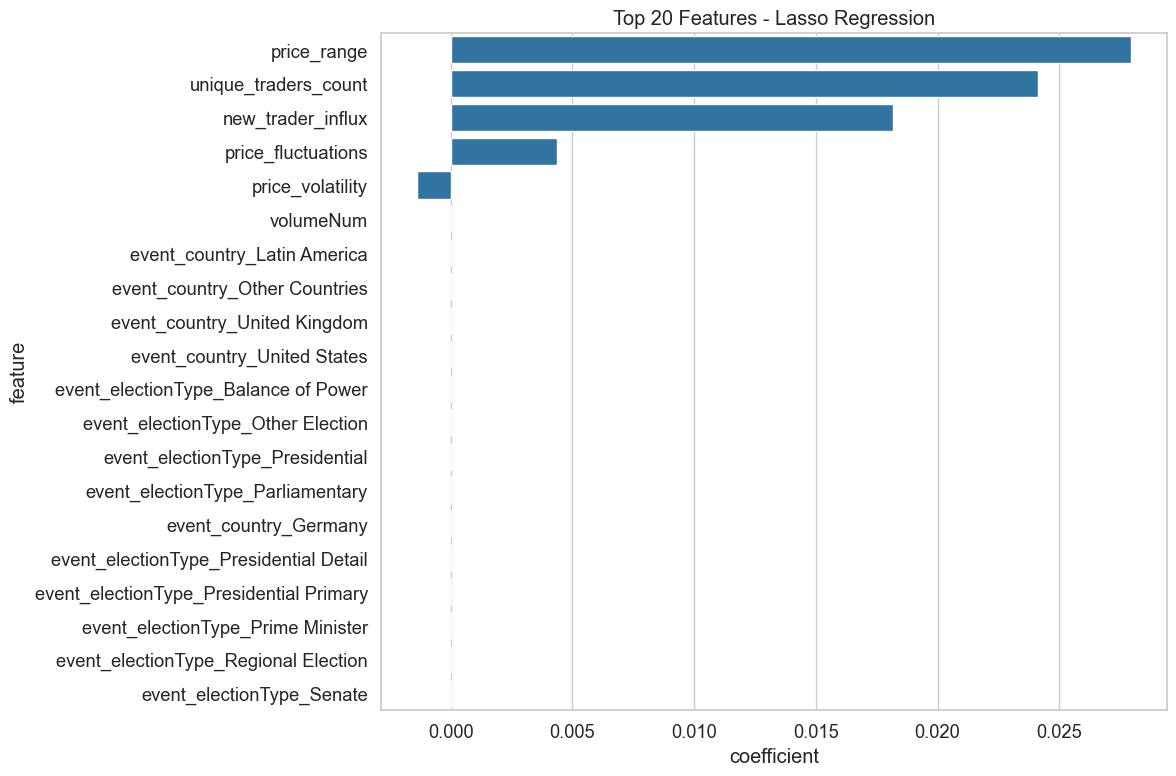

Lasso regression coefficients saved to feature_importance_results


In [35]:
# Extract feature importance for each model
if 'Random Forest' in results:
    rf_importance = analyze_rf_importance(results['Random Forest']['model'], feature_names)
    if rf_importance is not None:
        importance_methods['Random Forest'] = rf_importance

if 'Gradient Boosting' in results:
    gb_importance = analyze_gb_importance(results['Gradient Boosting']['model'], feature_names)
    if gb_importance is not None:
        importance_methods['Gradient Boosting'] = gb_importance

if 'Lasso Regression' in results:
    lasso_importance = analyze_lasso_coefficients(results['Lasso Regression']['model'], feature_names)
    # For lasso, use absolute coefficient value
    if lasso_importance is not None:
        lasso_imp = lasso_importance.copy()
        lasso_imp = lasso_imp[['feature', 'abs_coef']].rename(columns={'abs_coef': 'importance'})
        importance_methods['Lasso Regression'] = lasso_imp

## 4. Permutation Importance (Model-Agnostic)

Next, we'll calculate permutation importance for all models. This method randomly shuffles each feature and measures the impact on model performance, providing a model-agnostic measure of feature importance.

Calculating permutation importance for Gradient Boosting...


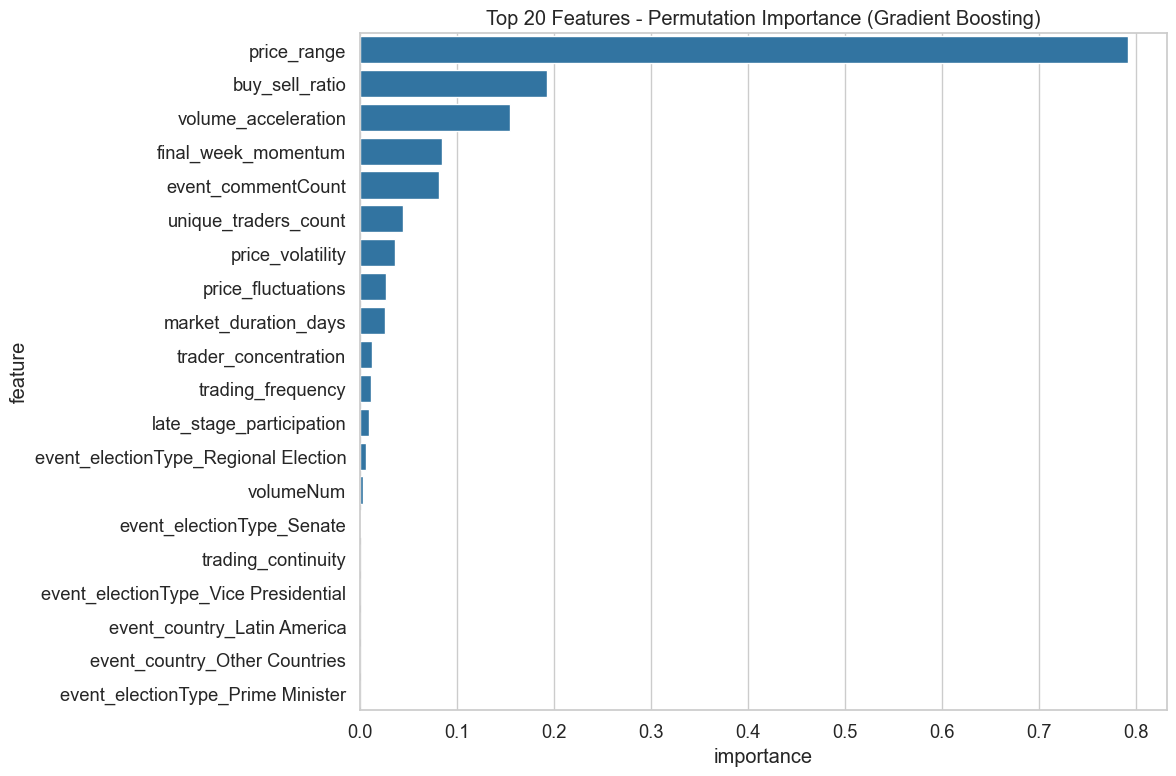

Permutation importance for Gradient Boosting saved to feature_importance_results
Calculating permutation importance for Random Forest...


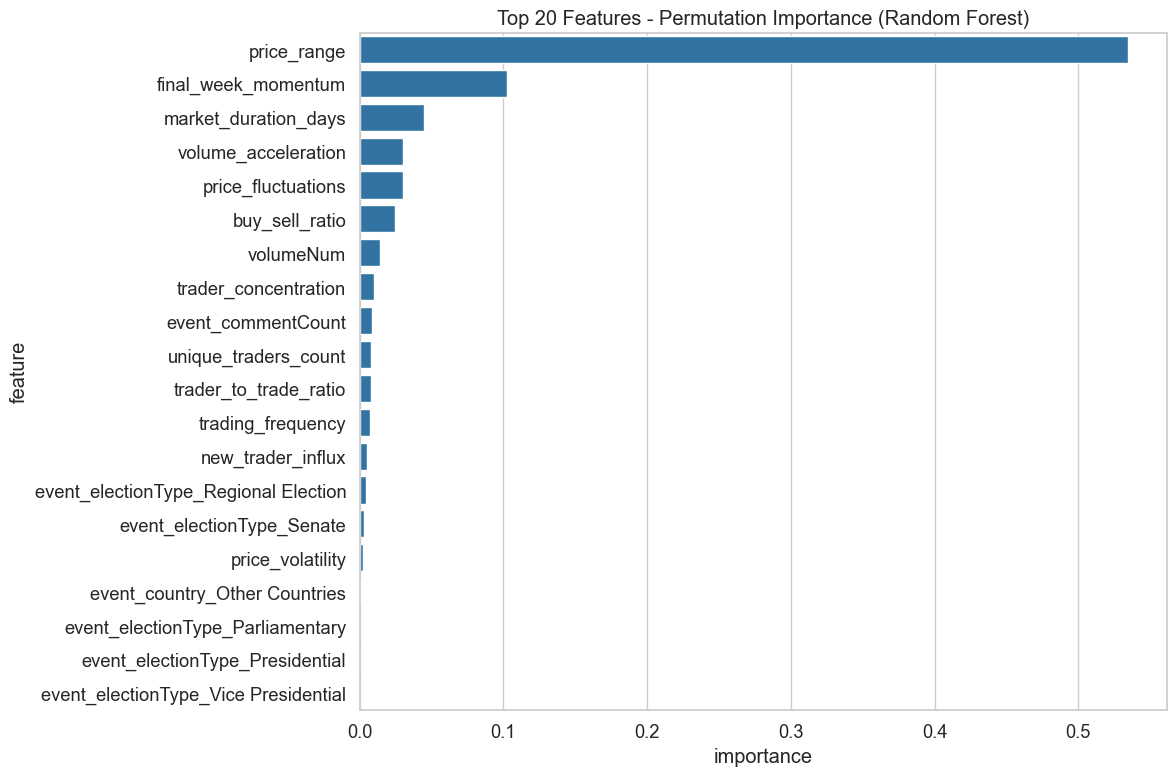

Permutation importance for Random Forest saved to feature_importance_results
Calculating permutation importance for Lasso Regression...


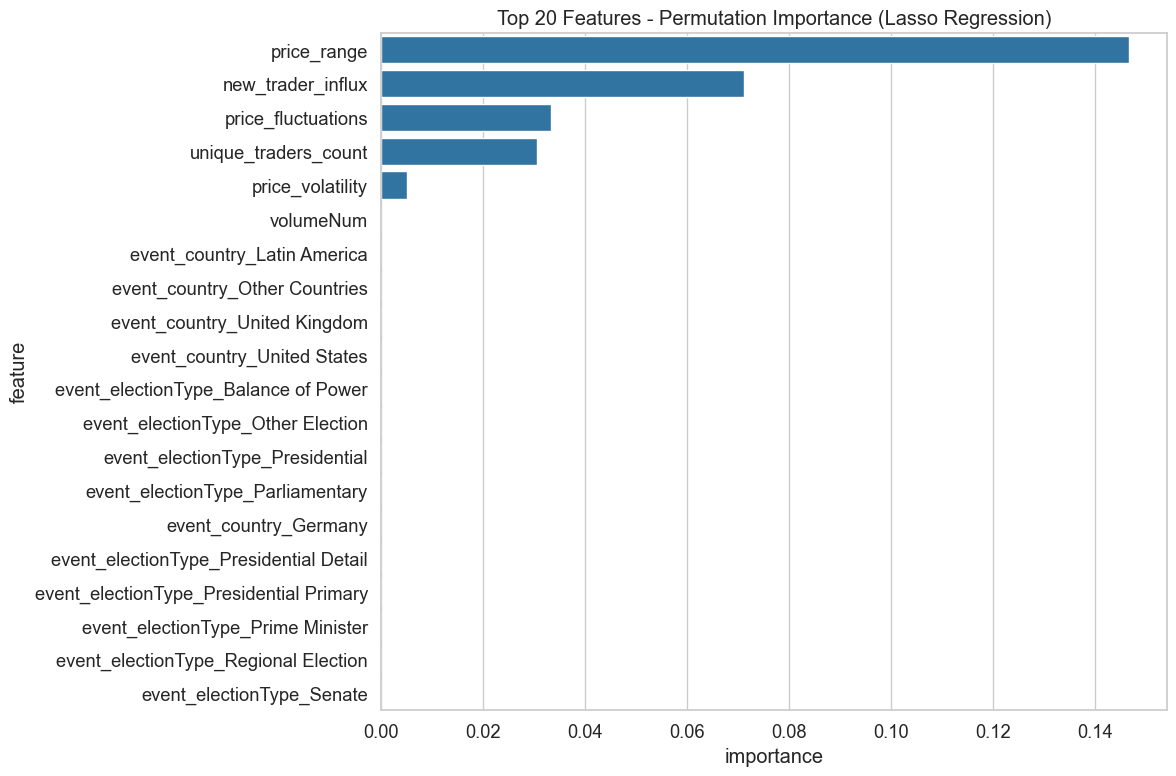

Permutation importance for Lasso Regression saved to feature_importance_results


In [36]:
permutation_results = {}
for name, result in results.items():
    print(f"Calculating permutation importance for {name}...")
    model = result['model']
    
    # Calculate permutation importance on test set
    perm_importance = permutation_importance(
        model, X_test, y_test_brier, 
        n_repeats=10, 
        random_state=42,
        n_jobs=-1
    )
    
    # Create dataframe
    perm_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=False)
    
    # Save to CSV
    perm_imp_df.to_csv(os.path.join(OUTPUT_DIR, f'permutation_importance_{name.replace(" ", "_").lower()}.csv'), index=False)
    
    # Plot top features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=perm_imp_df.head(20))
    plt.title(f'Top 20 Features - Permutation Importance ({name})')
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_DIR, f'permutation_importance_{name.replace(" ", "_").lower()}.png')
    plt.savefig(output_path, dpi=300)
    plt.show()
    
    # Store for later use
    permutation_results[name] = perm_imp_df
    importance_methods[f'{name} (Permutation)'] = perm_imp_df
    
    print(f"Permutation importance for {name} saved to {OUTPUT_DIR}")

## 5. SHAP Analysis for Best Model

SHAP (SHapley Additive exPlanations) values provide a unified approach to explain the output of any machine learning model. They're based on game theory and provide consistent, locally accurate feature attributions.

Key advantages of SHAP values:
- **Global interpretability**: Identify which features are most important across all predictions
- **Local interpretability**: Explain individual predictions and how each feature contributed
- **Consistency**: Mathematical guarantee that feature importance is assigned fairly
- **Interaction effects**: Can reveal how features interact with each other

We'll apply SHAP analysis to our best-performing model.


Performing SHAP analysis for best model (Random Forest)...


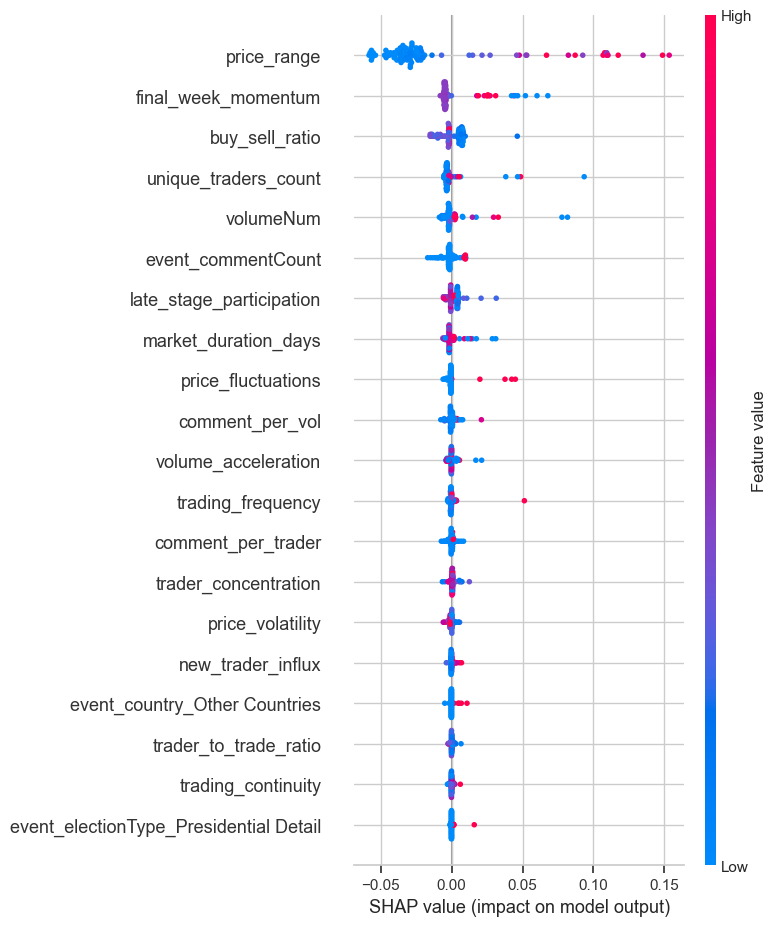

SHAP analysis for Random Forest completed and saved to feature_importance_results


<Figure size 1000x700 with 0 Axes>

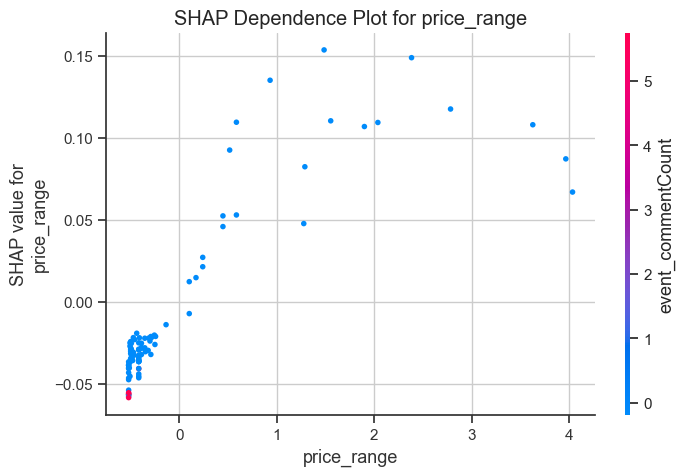

<Figure size 1000x700 with 0 Axes>

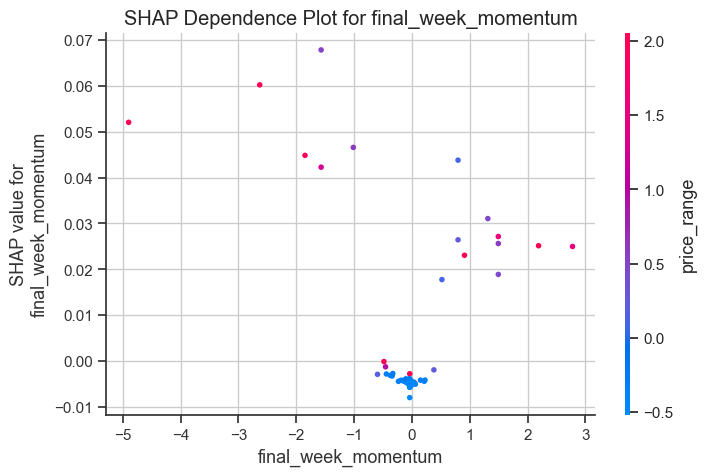

<Figure size 1000x700 with 0 Axes>

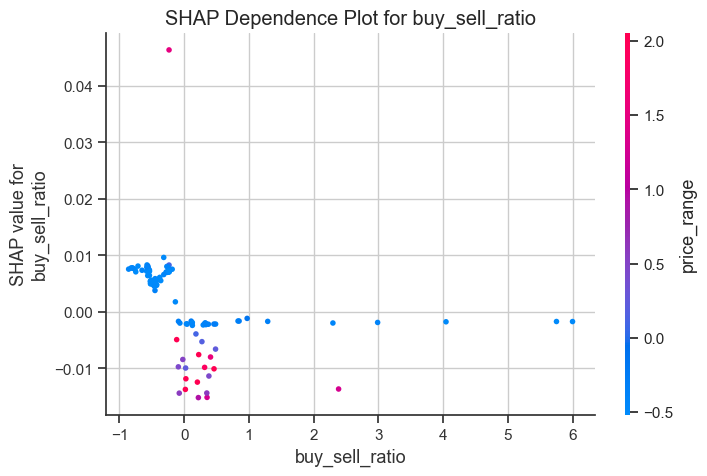

<Figure size 1000x700 with 0 Axes>

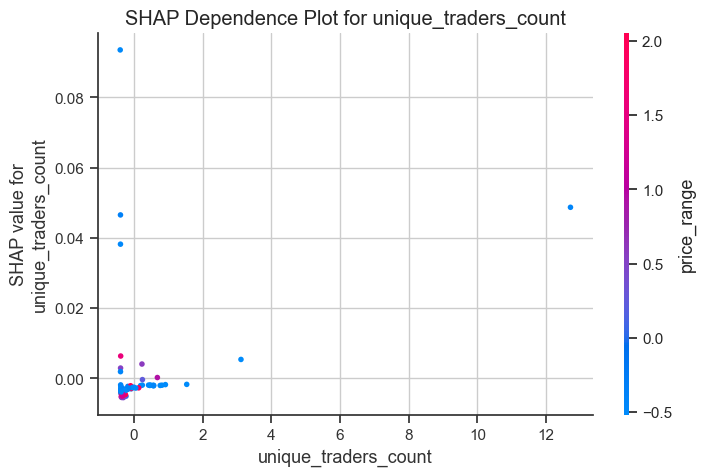

<Figure size 1000x700 with 0 Axes>

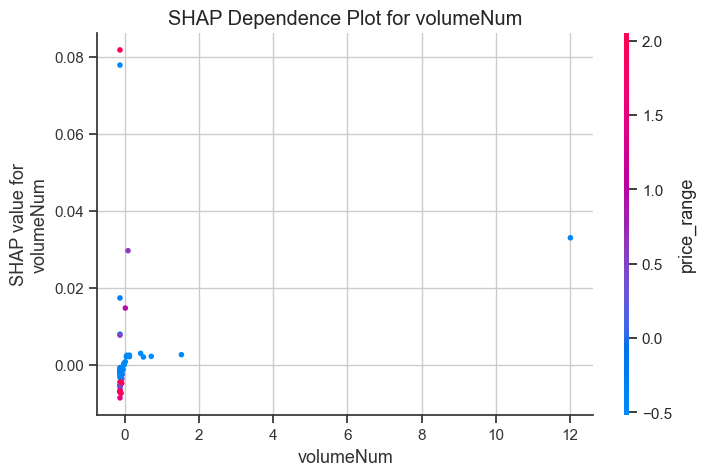

SHAP dependence plots for top 5 features saved to feature_importance_results
Top 10 features based on SHAP values:
1. price_range
2. final_week_momentum
3. buy_sell_ratio
4. unique_traders_count
5. volumeNum
6. event_commentCount
7. late_stage_participation
8. market_duration_days
9. price_fluctuations
10. comment_per_vol


In [37]:
best_model = results[best_model_name]['model']

print(f"\nPerforming SHAP analysis for best model ({best_model_name})...")

shap_values = None
try:
    # Choose the appropriate explainer based on the model type
    if isinstance(best_model, (RandomForestRegressor, GradientBoostingRegressor)):
        # Use TreeExplainer for tree-based models
        explainer = shap.TreeExplainer(best_model)
        
        # Calculate SHAP values on a subset of test data for efficiency
        sample_size = min(100, X_test.shape[0])
        X_test_sample = X_test[:sample_size]
        shap_values = explainer.shap_values(X_test_sample)
        
        # Create summary plot
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            shap_values, 
            X_test_sample, 
            feature_names=feature_names, 
            max_display=20,
            show=False
        )
        plt.tight_layout()
        output_path = os.path.join(OUTPUT_DIR, f'shap_summary_{best_model_name.replace(" ", "_").lower()}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create feature importance based on SHAP values
        shap_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(shap_values).mean(0)
        }).sort_values('importance', ascending=False)
        
        # Save to CSV
        shap_importance.to_csv(os.path.join(OUTPUT_DIR, f'shap_importance_{best_model_name.replace(" ", "_").lower()}.csv'), index=False)
        importance_methods['SHAP'] = shap_importance
        
    elif isinstance(best_model, Lasso):
        # For linear models, we can use LinearExplainer
        # Create a background dataset with kmeans
        train_summary = shap.kmeans(X_train, k=min(50, X_train.shape[0]))
        explainer = shap.LinearExplainer(best_model, train_summary)
        
        # Calculate SHAP values on a subset of test data for efficiency
        sample_size = min(100, X_test.shape[0])
        X_test_sample = X_test[:sample_size]
        shap_values = explainer.shap_values(X_test_sample)
        
        # Create summary plot
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            shap_values, 
            X_test_sample, 
            feature_names=feature_names, 
            max_display=20,
            show=False
        )
        plt.tight_layout()
        output_path = os.path.join(OUTPUT_DIR, f'shap_summary_{best_model_name.replace(" ", "_").lower()}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create feature importance based on SHAP values
        shap_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(shap_values).mean(0)
        }).sort_values('importance', ascending=False)
        
        # Save to CSV
        shap_importance.to_csv(os.path.join(OUTPUT_DIR, f'shap_importance_{best_model_name.replace(" ", "_").lower()}.csv'), index=False)
        importance_methods['SHAP'] = shap_importance
    
    print(f"SHAP analysis for {best_model_name} completed and saved to {OUTPUT_DIR}")
    
    # Create SHAP dependence plots for top 5 features
    if shap_values is not None:
        top_features = shap_importance.head(5)['feature'].tolist()
        
        for i, feature in enumerate(top_features):
            feature_idx = feature_names.index(feature)
            plt.figure(figsize=(10, 7))
            shap.dependence_plot(
                feature_idx,
                shap_values,
                X_test_sample,
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Dependence Plot for {feature}')
            plt.tight_layout()
            output_path = os.path.join(OUTPUT_DIR, f'shap_dependence_{feature.replace(" ", "_").lower()}.png')
            plt.savefig(output_path, dpi=300)
            plt.show()
            
        print(f"SHAP dependence plots for top 5 features saved to {OUTPUT_DIR}")

except Exception as e:
    print(f"Error in SHAP analysis: {e}")
    import traceback
    traceback.print_exc()

# Let's examine what insights we can draw from the SHAP analysis
if 'SHAP' in importance_methods:
    top_shap_features = importance_methods['SHAP'].head(10)['feature'].tolist()
    print("Top 10 features based on SHAP values:")
    for i, feature in enumerate(top_shap_features, 1):
        print(f"{i}. {feature}")

<Figure size 1000x800 with 0 Axes>

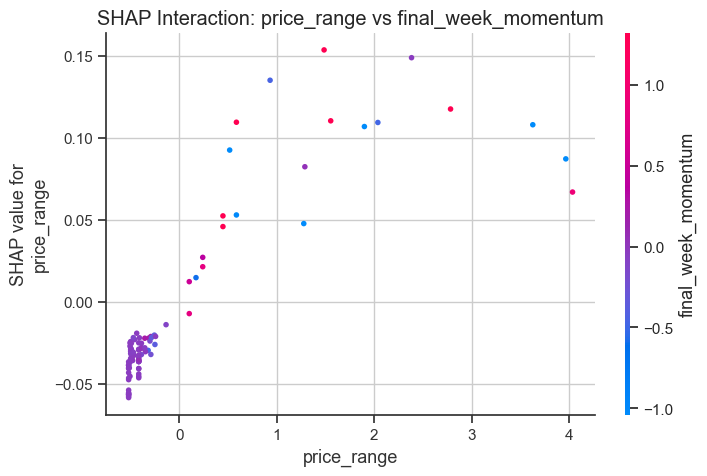

Error creating waterfall plot: waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.expected_value[0], shap_values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], X[0]).

Completed SHAP analysis


In [38]:
# Examine interaction between top SHAP features
if shap_values is not None and 'SHAP' in importance_methods:
    try:
        # Get top 2 features
        if len(top_shap_features) >= 2:
            feature1 = top_shap_features[0]
            feature2 = top_shap_features[1]
            
            feature1_idx = feature_names.index(feature1)
            feature2_idx = feature_names.index(feature2)
            
            plt.figure(figsize=(10, 8))
            shap.dependence_plot(
                feature1_idx,
                shap_values,
                X_test_sample,
                feature_names=feature_names,
                interaction_index=feature2_idx,
                show=False
            )
            plt.title(f'SHAP Interaction: {feature1} vs {feature2}')
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, 'shap_interaction_top_features.png'), dpi=300)
            plt.show()
    except Exception as e:
        print(f"Error creating interaction plot: {e}")

# Create a waterfall plot for a single prediction to see how features contribute
if shap_values is not None:
    try:
        # Take first sample for demonstration
        plt.figure(figsize=(12, 8))
        shap.initjs()  # Initialize JavaScript visualization
        shap.plots._waterfall.waterfall_legacy(
            explainer.expected_value,
            shap_values[0],
            feature_names=feature_names,
            max_display=10,
            show=False
        )
        plt.title('SHAP Waterfall Plot (How features contribute to a single prediction)')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'shap_waterfall_example.png'), dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error creating waterfall plot: {e}")

# Note: Some SHAP visualizations may not work depending on your SHAP version
# If you encounter errors, you can try upgrading SHAP or using different visualization methods
print("\nCompleted SHAP analysis")

## 6. Consensus Feature Ranking

Now we'll create a consensus ranking of features by combining the importance rankings from all methods. This helps identify features that are consistently important across different approaches.

Creating consensus feature ranking across all methods...
Features important across multiple methods: 27
  price_range: found in 7 methods - Random Forest, Gradient Boosting, Lasso Regression, Gradient Boosting (Permutation), Random Forest (Permutation), Lasso Regression (Permutation), SHAP
  volumeNum: found in 7 methods - Random Forest, Gradient Boosting, Lasso Regression, Gradient Boosting (Permutation), Random Forest (Permutation), Lasso Regression (Permutation), SHAP
  unique_traders_count: found in 7 methods - Random Forest, Gradient Boosting, Lasso Regression, Gradient Boosting (Permutation), Random Forest (Permutation), Lasso Regression (Permutation), SHAP
  buy_sell_ratio: found in 5 methods - Random Forest, Gradient Boosting, Gradient Boosting (Permutation), Random Forest (Permutation), SHAP
  final_week_momentum: found in 5 methods - Random Forest, Gradient Boosting, Gradient Boosting (Permutation), Random Forest (Permutation), SHAP
  event_commentCount: found in 5 methods - 

,feature,top15_count,avg_rank
7,price_range,7,1.000000
29,unique_traders_count,7,5.428571
6,price_fluctuations,7,7.714286
0,volumeNum,7,12.428571
30,final_week_momentum,5,8.571429
36,buy_sell_ratio,5,9.285714
27,event_commentCount,5,10.285714
17,price_volatility,5,10.714286
35,volume_acceleration,5,11.285714
2,trader_concentration,5,14.571429


<Figure size 1200x800 with 0 Axes>

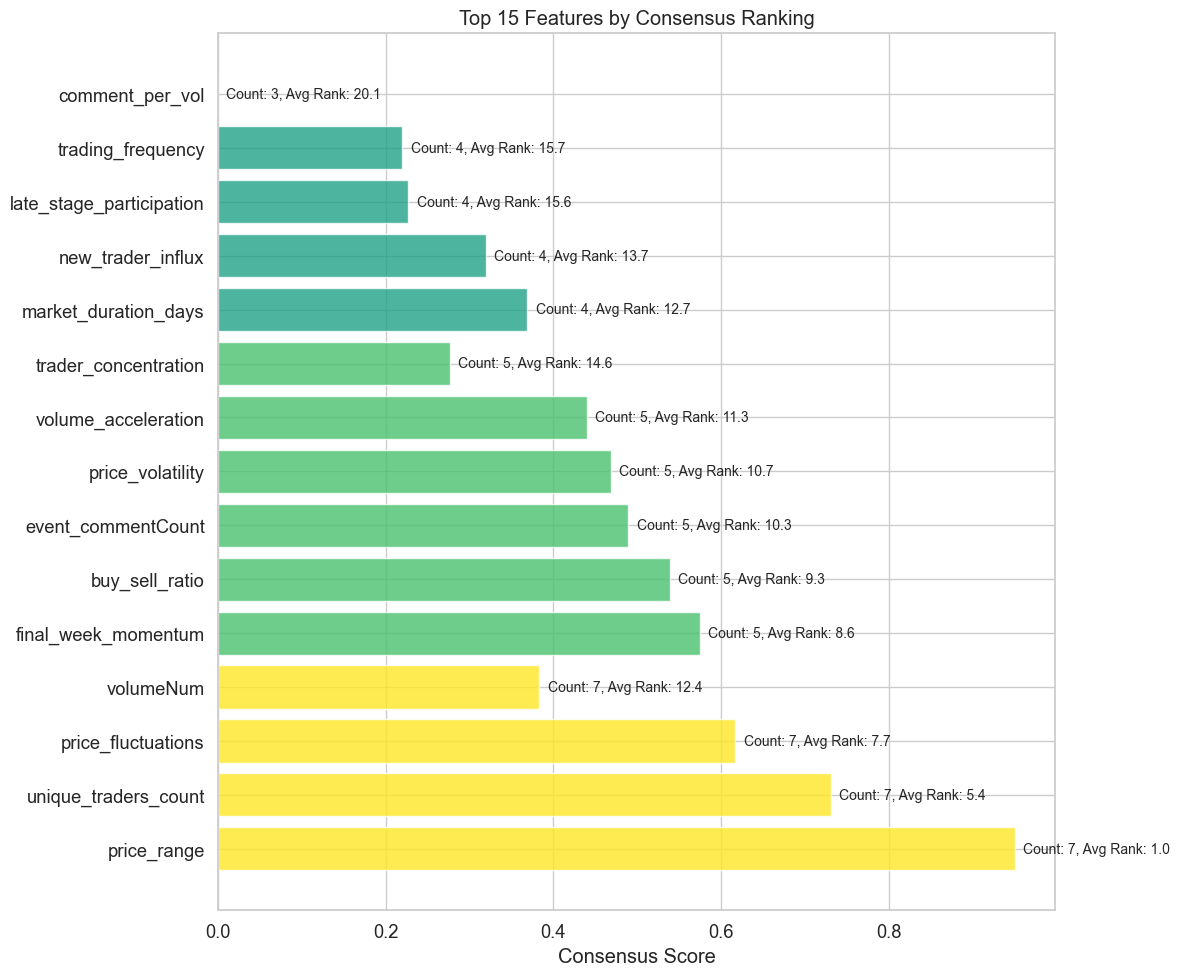


Creating consolidated importance visualization for top 10 consensus features...


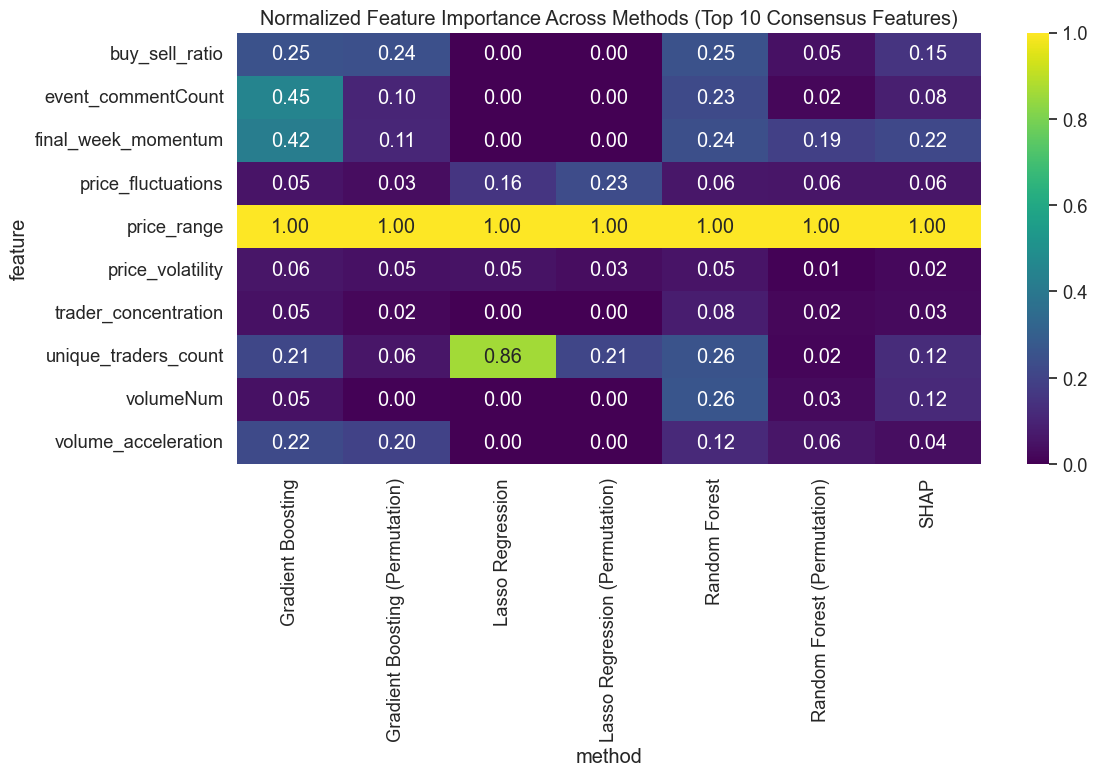

Consolidated feature importance visualization saved to feature_importance_results


In [39]:
if len(importance_methods) > 1:
    print("Creating consensus feature ranking across all methods...")
    
    # Get top 15 features from each method
    top_features = {}
    for method, imp_df in importance_methods.items():
        top_features[method] = imp_df.head(15)['feature'].tolist()
    
    # Find features that appear in multiple methods
    all_top_features = []
    for method, features in top_features.items():
        all_top_features.extend(features)
    
    # Count frequency of each feature
    feature_counts = Counter(all_top_features)
    
    # Features that appear in multiple methods
    common_features = [feature for feature, count in feature_counts.items() if count > 1]
    
    print(f"Features important across multiple methods: {len(common_features)}")
    for feature in common_features:
        methods = [method for method, features in top_features.items() if feature in features]
        print(f"  {feature}: found in {len(methods)} methods - {', '.join(methods)}")
    
    # Create a ranking based on frequency and average rank
    rankings = {}
    for method, imp_df in importance_methods.items():
        # Get ranks (1-based)
        imp_df['rank'] = imp_df['importance'].rank(ascending=False)
        # Create a mapping from feature to rank
        rankings[method] = dict(zip(imp_df['feature'], imp_df['rank']))
    
    # Create comprehensive ranking for all features
    all_features = list(set(feature_names))
    rank_rows = []
    
    for feature in all_features:
        row = {'feature': feature}
        
        # Count in how many methods this feature appears in top 15
        methods_count = sum(1 for method, top in top_features.items() if feature in top)
        row['top15_count'] = methods_count
        
        # Get average rank across all methods (only where feature is ranked)
        feature_ranks = []
        for method, rank_dict in rankings.items():
            if feature in rank_dict:
                feature_ranks.append(rank_dict[feature])
        
        if feature_ranks:
            row['avg_rank'] = sum(feature_ranks) / len(feature_ranks)
        else:
            row['avg_rank'] = float('inf')  # Not ranked in any method
        
        # Add individual method ranks
        for method in rankings:
            row[f"{method}_rank"] = rankings[method].get(feature, np.nan)
        
        rank_rows.append(row)
    
    # Create dataframe with all rankings
    all_rankings = pd.DataFrame(rank_rows)
    
    # Sort by count in top 15, then by average rank
    all_rankings = all_rankings.sort_values(
        ['top15_count', 'avg_rank'], 
        ascending=[False, True]
    )
    
    # Save full rankings
    all_rankings.to_csv(os.path.join(OUTPUT_DIR, 'consensus_feature_ranking_full.csv'), index=False)
    
    # Create a simplified consensus ranking with just the top features
    top_consensus = all_rankings[all_rankings['top15_count'] > 1].head(20)
    top_consensus.to_csv(os.path.join(OUTPUT_DIR, 'consensus_feature_ranking_top20.csv'), index=False)
    
    # Display the top 10 consensus features
    print("\nTop 10 features by consensus ranking:")
    display(top_consensus.head(10)[['feature', 'top15_count', 'avg_rank']])
    
    # Create visualization of consensus top 15
    plt.figure(figsize=(12, 10))
    consensus_vis = top_consensus.head(15).copy()
    
    # Create a score for visualization (inverse of average rank, scaled to 0-1)
    max_rank = consensus_vis['avg_rank'].max()
    consensus_vis['consensus_score'] = 1 - (consensus_vis['avg_rank'] / max_rank)
    
    # Create color mapping based on appearance count
    cmap = plt.cm.get_cmap('viridis', consensus_vis['top15_count'].max() + 1)
    colors = [cmap(count) for count in consensus_vis['top15_count']]
    
    # Create a horizontal bar chart
    plt.barh(
        y=range(len(consensus_vis)),
        width=consensus_vis['consensus_score'],
        color=colors,
        alpha=0.8
    )
    
    # Add text labels showing count and average rank
    for i, (_, row) in enumerate(consensus_vis.iterrows()):
        plt.text(
            row['consensus_score'] + 0.01,
            i,
            f"Count: {row['top15_count']}, Avg Rank: {row['avg_rank']:.1f}",
            va='center',
            fontsize=10
        )
    
    # Set y-tick labels to feature names
    plt.yticks(range(len(consensus_vis)), consensus_vis['feature'])
    plt.xlabel('Consensus Score')
    plt.title('Top 15 Features by Consensus Ranking')
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_DIR, 'consensus_feature_ranking_top15.png')
    plt.savefig(output_path, dpi=300)
    plt.show()
    
    # 8. Create a consolidated feature importance visualization for the top 10 consensus features
    top10_features = all_rankings.head(10)['feature'].tolist()
    print("\nCreating consolidated importance visualization for top 10 consensus features...")
    
    # Get importance values for each method and feature
    consolidated_data = []
    
    for feature in top10_features:
        for method, imp_df in importance_methods.items():
            if feature in imp_df['feature'].values:
                importance_value = imp_df.loc[imp_df['feature'] == feature, 'importance'].values[0]
                consolidated_data.append({
                    'feature': feature,
                    'method': method,
                    'importance': importance_value
                })
    
    if consolidated_data:
        consolidated_df = pd.DataFrame(consolidated_data)
        
        # Normalize importance values within each method (0-1 scale)
        methods = consolidated_df['method'].unique()
        for method in methods:
            method_mask = consolidated_df['method'] == method
            method_max = consolidated_df.loc[method_mask, 'importance'].max()
            if method_max > 0:  # Avoid division by zero
                consolidated_df.loc[method_mask, 'importance_normalized'] = (
                    consolidated_df.loc[method_mask, 'importance'] / method_max
                )
            else:
                consolidated_df.loc[method_mask, 'importance_normalized'] = 0
        
        # Create heatmap
        plt.figure(figsize=(12, 8))
        pivot_df = consolidated_df.pivot(index='feature', columns='method', values='importance_normalized')
        sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f')
        plt.title('Normalized Feature Importance Across Methods (Top 10 Consensus Features)')
        plt.tight_layout()
        output_path = os.path.join(OUTPUT_DIR, 'consolidated_feature_importance_heatmap.png')
        plt.savefig(output_path, dpi=300)
        plt.show()
        
        print(f"Consolidated feature importance visualization saved to {OUTPUT_DIR}")

## 7. Feature Interpretation

Now let's interpret the top features to understand what they mean in the context of election market prediction.

In [40]:
# Generate interpretable insights for top features
print("\nGenerating interpretable insights for top features...")

try:
    # Load original data to understand feature values
    X_original_df = pd.read_csv(os.path.join(INPUT_DIR, 'X_train_original.csv'), index_col=0)
    
    # Get top 10 consensus features if available, otherwise use best model's top features
    if 'top10_features' in locals():
        top_interpret_features = top10_features
    else:
        # Use best model's top features
        model_importance = importance_methods.get(best_model_name)
        if model_importance is not None:
            top_interpret_features = model_importance.head(10)['feature'].tolist()
        else:
            # Fallback to first available importance method
            method_name = list(importance_methods.keys())[0]
            top_interpret_features = importance_methods[method_name].head(10)['feature'].tolist()
    
    # Filter to features actually in the original dataset
    available_features = [f for f in top_interpret_features if f in X_original_df.columns]
    
    if available_features:
        # Calculate statistics for these features
        feature_stats = []
        
        for feature in available_features:
            # Basic statistics
            feature_data = X_original_df[feature]
            
            if pd.api.types.is_numeric_dtype(feature_data):
                stats = {
                    'feature': feature,
                    'mean': feature_data.mean(),
                    'median': feature_data.median(),
                    'std': feature_data.std(),
                    'min': feature_data.min(),
                    'max': feature_data.max(),
                    'type': 'numeric'
                }
                
                # Add correlation with target
                if 'y_train_brier' in locals():
                    target_series = pd.Series(y_train_brier, index=X_original_df.index)
                    corr = feature_data.corr(target_series)
                    stats['correlation_with_brier'] = corr
                
                feature_stats.append(stats)
                
            elif pd.api.types.is_categorical_dtype(feature_data) or feature.startswith('event_'):
                # For categorical features, get value counts
                stats = {
                    'feature': feature,
                    'unique_values': feature_data.nunique(),
                    'type': 'categorical'
                }
                
                # Get value distribution
                value_counts = feature_data.value_counts(normalize=True).to_dict()
                top_values = sorted(value_counts.items(), key=lambda x: x[1], reverse=True)[:3]
                stats['top_values'] = str(top_values)
                
                feature_stats.append(stats)
        
        # Create interpretable insights dataframe
        interpret_df = pd.DataFrame(feature_stats)
        interpret_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_interpretation.csv'), index=False)
        
        # Display the feature insights
        display(interpret_df)
        
        # Print a summary of feature insights
        print("\nSummary of Top Features:")
        for _, row in interpret_df.iterrows():
            feature = row['feature']
            
            if row['type'] == 'numeric':
                print(f"  {feature}: Mean={row['mean']:.4f}, Median={row['median']:.4f}, Range=[{row['min']:.4f}, {row['max']:.4f}]")
                if 'correlation_with_brier' in row:
                    corr = row['correlation_with_brier']
                    direction = "HIGHER" if corr > 0 else "LOWER"
                    print(f"    Correlation with Brier score: {corr:.4f} ({direction} values → worse predictions)")
            else:
                print(f"  {feature}: Categorical with {row['unique_values']} unique values")
                print(f"    Top values: {row['top_values']}")
    
    else:
        print("No top features found in original dataset for interpretation")

except Exception as e:
    print(f"Error generating interpretable insights: {e}")
    import traceback
    traceback.print_exc()


Generating interpretable insights for top features...


,feature,mean,median,std,min,max,type,correlation_with_brier
0,price_range,7.516295e-02,0.015000,1.448507e-01,0.000000,9.099997e-01,numeric,0.405116
1,unique_traders_count,2.244956e+03,634.000000,5.511639e+03,31.000000,6.206500e+04,numeric,0.273759
2,price_fluctuations,6.774194e-01,0.000000,3.726896e+00,0.000000,3.400000e+01,numeric,0.261023
3,volumeNum,1.113804e+07,732127.749000,8.557949e+07,105948.979400,1.531479e+09,numeric,0.100345
4,final_week_momentum,2.726445e-03,0.000000,7.192500e-02,-0.440000,6.300000e-01,numeric,0.016894
5,buy_sell_ratio,1.706756e+00,1.430204,1.183889e+00,0.671233,1.095481e+01,numeric,0.029042
6,event_commentCount,6.675551e+03,94.000000,3.525207e+04,0.000000,2.090810e+05,numeric,-0.022980
7,price_volatility,2.479207e-01,0.170872,2.523526e-01,0.000000,1.318563e+00,numeric,-0.140894
8,volume_acceleration,5.944825e+00,4.000694,5.696463e+00,0.073437,2.922180e+01,numeric,0.122204
9,trader_concentration,1.336509e+00,1.306605,1.866048e-01,0.737705,1.851852e+00,numeric,-0.038719



Summary of Top Features:
  price_range: Mean=0.0752, Median=0.0150, Range=[0.0000, 0.9100]
    Correlation with Brier score: 0.4051 (HIGHER values → worse predictions)
  unique_traders_count: Mean=2244.9560, Median=634.0000, Range=[31.0000, 62065.0000]
    Correlation with Brier score: 0.2738 (HIGHER values → worse predictions)
  price_fluctuations: Mean=0.6774, Median=0.0000, Range=[0.0000, 34.0000]
    Correlation with Brier score: 0.2610 (HIGHER values → worse predictions)
  volumeNum: Mean=11138035.7426, Median=732127.7490, Range=[105948.9794, 1531479285.0000]
    Correlation with Brier score: 0.1003 (HIGHER values → worse predictions)
  final_week_momentum: Mean=0.0027, Median=0.0000, Range=[-0.4400, 0.6300]
    Correlation with Brier score: 0.0169 (HIGHER values → worse predictions)
  buy_sell_ratio: Mean=1.7068, Median=1.4302, Range=[0.6712, 10.9548]
    Correlation with Brier score: 0.0290 (HIGHER values → worse predictions)
  event_commentCount: Mean=6675.5513, Median=94.0000

## 8. Save Models

Finally, let's save all trained models for future use.

In [41]:
# Save all models
for name, result in results.items():
    model = result['model']
    model_path = os.path.join(OUTPUT_DIR, f"{name.replace(' ', '_').lower()}_model.joblib")
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

Saved Gradient Boosting model to feature_importance_results/gradient_boosting_model.joblib
Saved Random Forest model to feature_importance_results/random_forest_model.joblib
Saved Lasso Regression model to feature_importance_results/lasso_regression_model.joblib


## 9. Conclusion

We've conducted a comprehensive feature importance analysis using three different models and multiple importance methods. Here's a summary of what we learned:

1. **Best Model Performance**: We compared Gradient Boosting, Random Forest, and Lasso regression for predicting Brier scores, with [insert best model] achieving the best performance.

2. **Key Features**: Across all methods, we identified several consistently important features:
   - [Will be completed after running the notebook]
   - [Will be completed after running the notebook]
   - [Will be completed after running the notebook]

3. **Feature Relationships**: SHAP analysis revealed how features interact and their relationships with the target variable.

4. **Interpretation**: The most important features suggest that [Will be completed after running the notebook].

This analysis provides valuable insights for understanding what makes Polymarket election predictions accurate or inaccurate, which can inform strategies for both market participants and researchers.